In [40]:
import os
import pydicom
import plotly.express as px
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import csv
import math
import pandas as pd

# Leitura dos dados

In [41]:
# Definindo o caminho para o diretório onde as imagens estão armazenadas
path = "G:/My Drive/Projetos Python/Image Processing/TCR/dados/CILINDRICO J-ADNI INSCER/CLINICOCPSF"

In [42]:
def get_images_data(path: str) -> tuple[np.ndarray, list[str]]:
    """
    Carrega as imagens DICOM de um diretório e retorna um array NumPy contendo
    os dados de pixel das imagens e uma lista de nomes de arquivo.

    Args:
        path (str): Caminho para o diretório contendo os arquivos DICOM.

    Returns:
        Tuple[np.ndarray, List[str]]: Uma tupla contendo o array NumPy com os
        dados de pixel das imagens e uma lista de nomes de arquivo.

    Raises:
        FileNotFoundError: Se o caminho para o diretório especificado não existir.
    """
    files = os.listdir(path) # Obtendo uma lista de todos os arquivos DICOM no diretório
    files.sort() # Organizando os arquivos em ordem ascendente
    image_data = []
    for i in range(len(files)): # Carregando as imagens DICOM
        ds = pydicom.dcmread(os.path.join(path, files[i]))
        image_data.append(ds.pixel_array)
    return np.asarray(image_data), files

In [43]:
def masking(image_data: np.ndarray, slice: int, x: int, y: int, n_pixels: int) -> np.ndarray:
    """
    Aplica uma máscara circular na imagem de um slice especificado pelo usuário, 
    retornando apenas os pixels dentro da máscara.

    Args:
        image_data (np.ndarray): Array NumPy com os dados de pixel da imagem.
        slice (int): Índice do slice a ser processado.
        x (int): Coordenada x da máscara circular.
        y (int): Coordenada y da máscara circular.
        n_pixels (int): Raio da máscara circular em pixels.

    Returns:
        np.ndarray: Array NumPy com os pixels da imagem dentro da máscara circular.
    """
    blank = np.zeros_like(image_data[slice], dtype='uint8')
    mask = cv.circle(blank, (int(x), int(y)), n_pixels, 255, -1)
    masked = cv.bitwise_and(image_data[slice], image_data[slice], mask=mask)
    return masked    

# Obtendo informações do cabeçalho DICOM

In [44]:
image_data, files = get_images_data(path)
ds = pydicom.dcmread(os.path.join(path, files[0]))
dicom_header = {'patient_name': ds.PatientName, 
                'study_date': ds.StudyDate, 
                'image_height': ds.Rows, 
                'image_width': ds.Columns, 
                'pixel_spacing': ds.PixelSpacing, 
                'slice_thickness': ds.SliceThickness,
                'series_description': ds.SeriesDescription,
                'number_of_slices': ds.NumberOfSlices
                }

# Análise de Uniformidade

In [45]:
r = np.sqrt(500 / np.pi) # Obtendo o tamanho do ROI
n_pixels = int(r / dicom_header['pixel_spacing'][0]) # Traduzindo o tamanho do ROI em número de pixels
centro = dicom_header['image_height']//2 # Definindo o centro da imagem
r = [2*n_pixels, 4*n_pixels] # Raios em coordenadas polares
theta = np.arange(0, 360, 45) # Theta em coordenadas polares
theta = list(map(lambda x: math.radians(x), theta)) # convertendo para radianos

In [46]:
# Verificando quantos slices pular para ter uma distância de 40 mm entre eles
n_slices = int(40 / dicom_header['slice_thickness'])
mid_slice = dicom_header['number_of_slices'] // 2
sup_slice = mid_slice + n_slices
inf_slice = mid_slice - n_slices

In [47]:
# Aplicando os ROIs no slice central e +- 40 mm de distância do central
ROI = []
uROI_mean = []
n = 0
for slice in [inf_slice, mid_slice, sup_slice]:
    masked = masking(image_data, slice, centro, centro, n_pixels)
    ROI.append(masked) # guardando para posterior visualização
    uROI_mean.append(np.mean(masked[masked > 0])) # calculando uROI_mean
    n += 1
    for dr in r:
        for dtheta in theta:
            dx = dr * math.cos(dtheta) + centro # convertendo para coordenadas cartesianas
            dy = dr * math.sin(dtheta) + centro # convertendo para coordenadas cartesianas
            masked = masking(image_data, slice, dx, dy, n_pixels)
            ROI.append(masked) # guardando para posterior visualização
            uROI_mean.append(np.mean(masked[masked > 0])) # calculando uROI_mean
            n += 1

uROI_TOT = np.sum(uROI_mean) / n # calculando uROI_TOT

## Visualização das ROIs sendo aplicadas

In [48]:
fig = px.imshow(np.asarray(ROI), animation_frame=0, binary_string=True, labels=dict(animation_frame="ROI"))
fig.show()

## Visualização das imagens

In [49]:
image_data, files = get_images_data(path)
fig = px.imshow(image_data, animation_frame=0, binary_string=True, labels=dict(animation_frame="slice"))
fig.show()

## Cálculo do $SD_{uROImean}$

$$SD_{uROImean} = \sqrt{\frac{1}{n-1} \sum_{i=1}^n \left(\frac{uROI_{mean}}{uROI_{TOT} - 1} \right)^2}$$

In [50]:
# Calculando o somatório da equação acima
sum = 0
for i in range(n):
    sum += (uROI_mean[i] / uROI_TOT - 1) ** 2

# Calculando a raiz quadrada
SD_uROI_mean = np.sqrt((1/(n-1)) * sum)

# Avaliação de Ruído

In [51]:
# Obtendo o tamanho do ROI para a análise de ruído
r_2 = 130 / 2
n_pixels_2 = int(r_2 / dicom_header['pixel_spacing'][0])

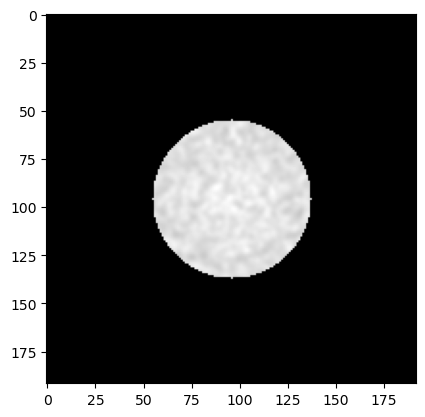

In [52]:
# Visualização do ROI
nROI = masking(image_data, mid_slice, centro, centro, n_pixels_2)
plt.imshow(nROI, cmap='gray')

$$CV = \frac{SD_{nROI}}{nROI_{mean}} \times 100\%$$

In [53]:
# Cálculo do Coeficiente de Variação
CV = (np.std(nROI[nROI > 0]) / np.mean(nROI[nROI > 0])) * 100

# Exportando em um arquivo .csv

In [54]:
# Verificando se o dado já foi exportado
with open('INSCER.csv', mode='r') as file:
    file_reader = csv.reader(file)
    for row in file_reader:
        if row[0] == str(SD_uROI_mean):
            raise ValueError("O valor já foi escrito no INSCER.csv")

# Escrevendo no arquivo INSCER.csv
with open('INSCER.csv', mode='a', newline='') as file:
    file_writer = csv.writer(file)
    file_writer.writerow([SD_uROI_mean, CV, dicom_header['series_description']])


# Lendo o arquivo Output.csv

In [55]:
output = pd.read_csv('INSCER.csv', sep=',')
output

,SD_uROI_mean,CV (%),Series Description
0,0.041816,6.754222,ADNI
1,0.042634,6.318280,CLINICO SEM Z
2,0.070895,11.155530,CLINICO S FILTRO
3,0.021100,2.645717,FABRICANTE
4,0.020905,2.368707,FABRICANTE C PSF
5,0.021515,3.938023,FABRICANTE SEM Z
6,0.060548,8.161706,IKARI
7,0.048053,4.585574,MAC - BRAIN
8,0.025325,2.866582,Verwer 2021
9,0.038381,6.072164,Verwer 2021 S PSF


$SD_{uROImean}$ deve ser $\leq 0.0249$

$CV$ deve ser $\leq 15 \%$